In [5]:
from courier import Courier

In [6]:
courier = Courier(x_origin = 12.117, y_origin=6.370, z_origin=0.06,
                  coordinates_path='../data/coordinates.csv',
                  edges_path='../data/edges.txt',
                  package_order=[1, 2, 3, 4], 
                  package_map= {
                    1: 13,
                    2: 12,
                    3: 18,
                    4: 21
                  })

In [7]:
courier.start_loop()

FINITO MOVIMENTO
FINITO MOVIMENTO
FINITO MOVIMENTO
FINITO MOVIMENTO
FINITO MOVIMENTO
FINITO MOVIMENTO
FINITO MOVIMENTO
FINITO MOVIMENTO
FINITO MOVIMENTO
FINITO MOVIMENTO
FINITO MOVIMENTO
FINITO MOVIMENTO
FINITO MOVIMENTO
FINITO MOVIMENTO
FINITO MOVIMENTO
FINITO MOVIMENTO
FINITO MOVIMENTO
FINITO MOVIMENTO
FINITO MOVIMENTO
FINITO MOVIMENTO
FINITO MOVIMENTO
FINITO MOVIMENTO
FINITO MOVIMENTO
FINITO MOVIMENTO
FINITO MOVIMENTO
FINITO MOVIMENTO
FINITO MOVIMENTO
FINITO MOVIMENTO
FINITO MOVIMENTO
FINITO MOVIMENTO
FINITO MOVIMENTO
FINITO MOVIMENTO
FINITO MOVIMENTO
FINITO MOVIMENTO
FINITO MOVIMENTO
FINITO MOVIMENTO
FINITO MOVIMENTO
FINITO MOVIMENTO
FINITO MOVIMENTO
FINITO MOVIMENTO
FINITO MOVIMENTO
FINITO MOVIMENTO
FINITO MOVIMENTO
FINITO MOVIMENTO
FINITO MOVIMENTO
FINITO MOVIMENTO
FINITO MOVIMENTO
FINITO MOVIMENTO
FINITO MOVIMENTO
FINITO MOVIMENTO
FINITO MOVIMENTO
FINITO MOVIMENTO
FINITO MOVIMENTO
FINITO MOVIMENTO
FINITO MOVIMENTO
FINITO MOVIMENTO
FINITO MOVIMENTO
FINITO MOVIMENTO
FINITO MOVIMEN

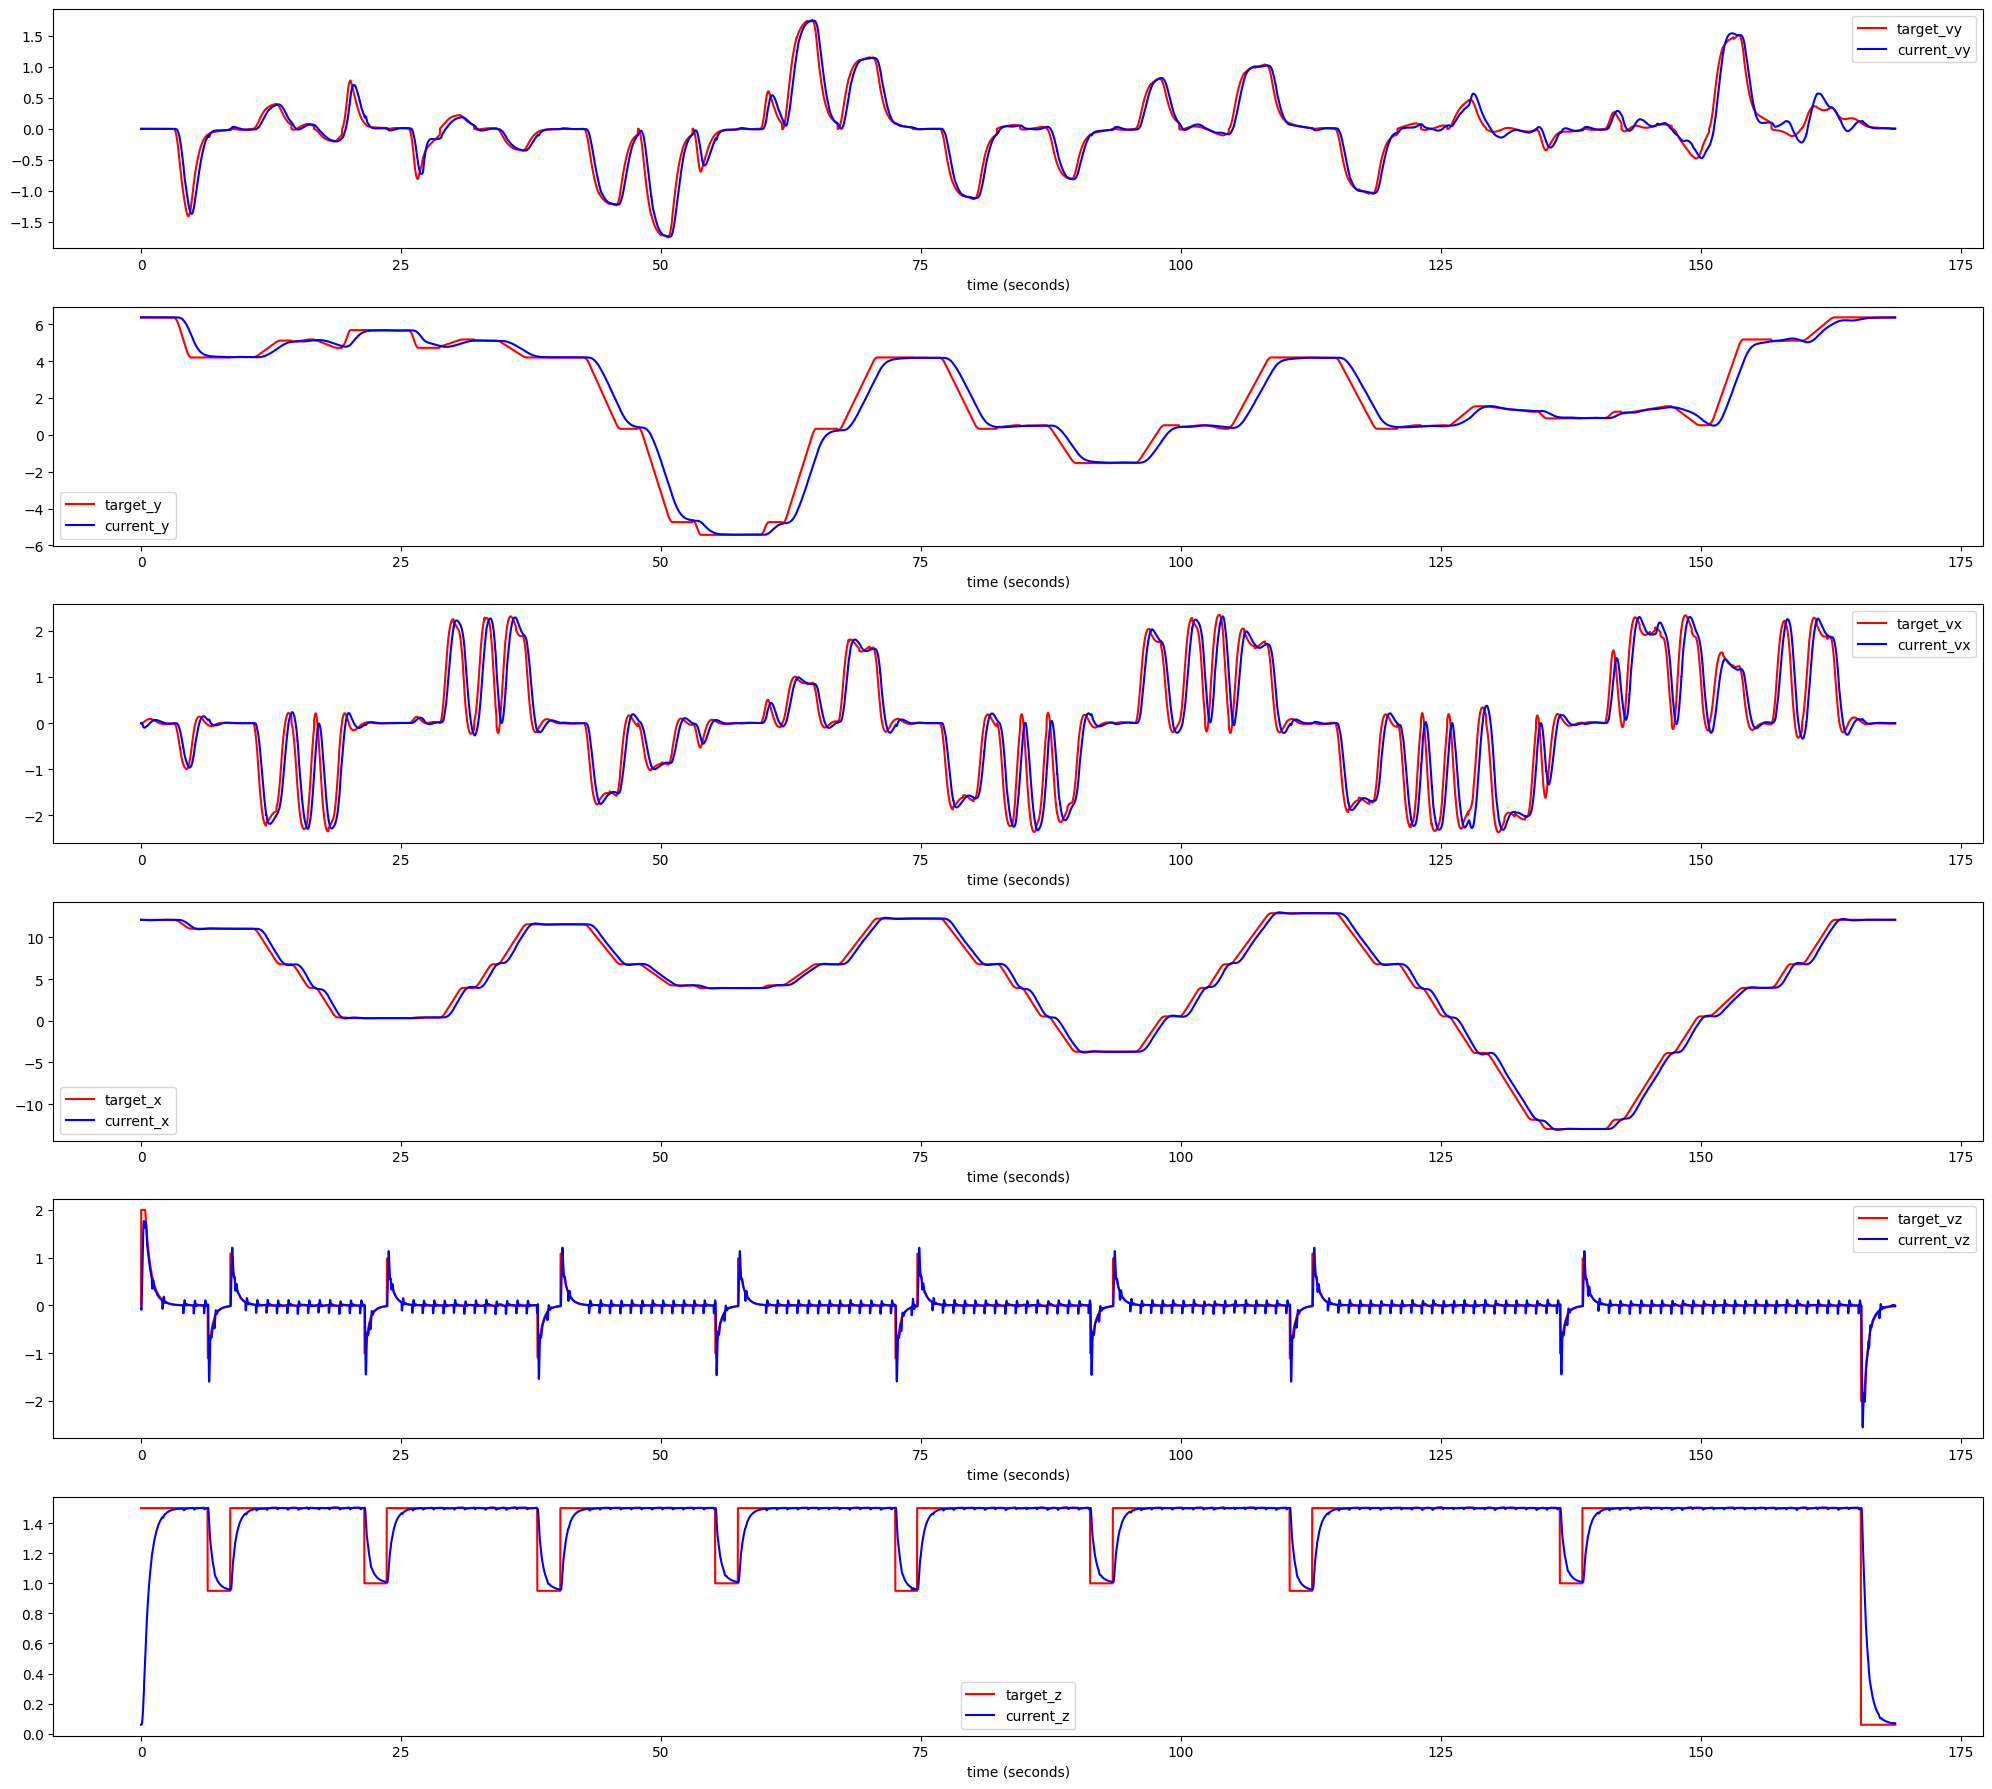

In [8]:
courier.plot_graph()